In [46]:
import segment
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
import diameter_calc
from typing import Union, Tuple
from skimage import measure
from scipy.ndimage import label
from skimage import morphology
from skimage.morphology import skeletonize
from sklearn.metrics import confusion_matrix, jaccard_score

In [2]:
img = cv2.imread("Images/image.png")

In [3]:
img = cv2.imread("Images/25046-retinal-imaging.jpg")

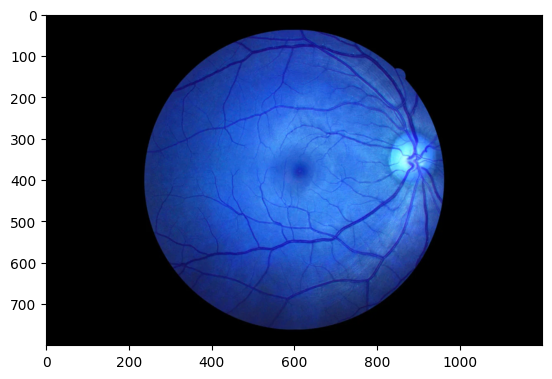

In [4]:
plt.imshow(img)

## HRF data

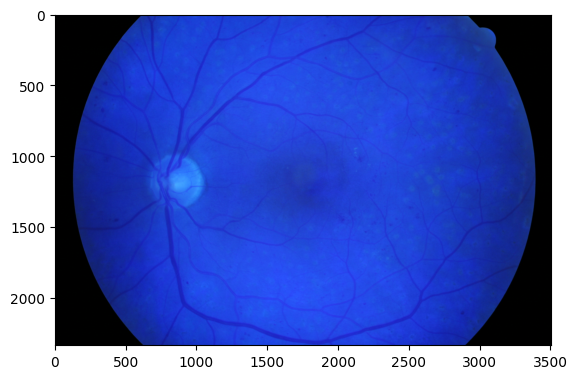

In [5]:
img = cv2.imread("Images/HRF/original/01_dr.JPG")
plt.imshow(img)

In [33]:
img.size

24556032

24556032

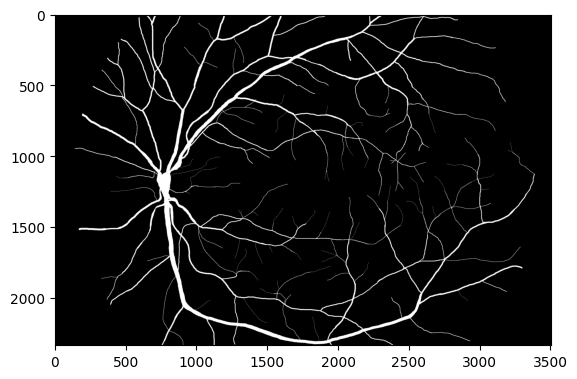

In [34]:
img_segment = cv2.imread("Images/HRF/manual_segment/01_dr.tif")
plt.imshow(img_segment)
img_segment.size

8185344

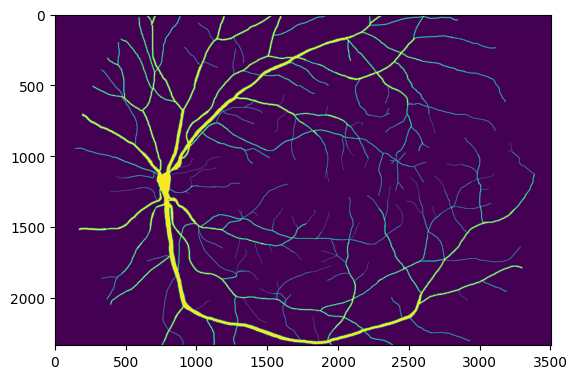

In [40]:
g_segment = img_segment[:,:,1]
plt.imshow(g_segment)
g_segment.size

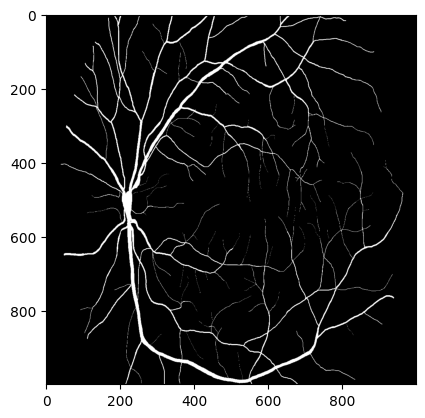

In [22]:
img_segment_1000 = cv2.resize(img_segment, (1000, 1000))
plt.imshow(img_segment_1000)

# Segmentation

In [23]:
def segmentation(img, t=8, A=200, L=50, resize=True):  
    """
    Employes a global thresholding based segmentation algorithm for retinal vessel segmentation

    Args:
        t: Threshold => the threshold used to segment the image (value of 8-10 works best. Otsu and Isodata values do not led to best result)
        A: Threshold area => All the segments less than A in area are to be removed and considered as noise
        L: Threshold length => All the centrelines less than L in length are to be removed
        resize: boolean => weather you want to resize the image to (1000px, 1000px)
    Returns:
        Segmented image
    """

    # Resize image to ~(1000px, 1000px) for best results
    if resize:
        img = cv2.resize(img, (1000, 1000))

    # Green Channel
    g = img[:,:,1]
    
    # Threshold the image
    # _, thresholded = cv2.threshold(img, 30, 255, cv2.THRESH_BINARY)
    #Creating mask for restricting FOV
    _, mask = cv2.threshold(g, 10, 255, cv2.THRESH_BINARY)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.erode(mask, kernel, iterations=3)
    
    # CLAHE and background estimation
    clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize=(9,9))
    g_cl = clahe.apply(g)
    g_cl1 = cv2.medianBlur(g_cl, 5)
    bg = cv2.GaussianBlur(g_cl1, (55, 55), 0)

    # Background subtraction
    norm = np.float32(bg) - np.float32(g_cl1)
    norm = norm*(norm>0)

    # Thresholding for segmentation
    _, t = cv2.threshold(norm, t, 255, cv2.THRESH_BINARY)

    # Removing noise points by coloring the contours
    t = np.uint8(t)
    th = t.copy()
    contours, hierarchy = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if ( cv2.contourArea(c)< A):
            cv2.drawContours(th, [c], 0, 0, -1)
    th = th*(mask/255)
    th = np.uint8(th)
    plt.imshow(th, cmap='gray')  # THE SEGMENTED IMAGE
        
    return th

1000000


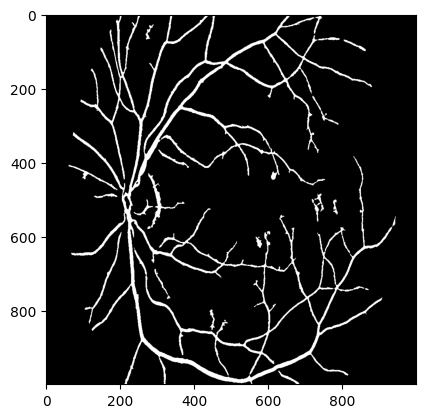

In [57]:
y_pred = segmentation(img, resize=True)
print(y_pred.size)
y_pred = y_pred.flatten() // 255

In [51]:
y_pred, len(y_pred)
y_pred.max()

1

In [58]:
y_true = img_segment_1000[:,:,1].flatten() // 255
y_true.max()

1

In [59]:
y_true, len(y_true)

(array([0, 0, 0, ..., 0, 0, 0], dtype=uint8), 1000000)

In [60]:
confusion_m = confusion_matrix(y_true, y_pred)

In [61]:
confusion_m

array([[917174,  40521],
       [  6507,  35798]])

In [62]:
jaccard_score(y_true, y_pred)

0.4322072779079033

## Complete implementation

In [93]:
def seg(img, t=8, A=200,L=50):  
    '''
    TBD
    
    Args:

    Returns:
    '''

    # t: Threshold => the threshold used to segment the image (value of 8-10 works best. Otsu and Isodata values do not led to best result)
    # A: Threshold area => All the segments less than A in area are to be removed and considered as noise
    # L: Threshold length => All the centrelines less than L in length are to be removed

    # Resize image to ~(1000px, 1000px) for best results
    img = cv2.resize(img, (1000, 1000))
    
    # Green Channel
    g = img[:,:,1]

    #Creating mask for restricting FOV
    _, mask = cv2.threshold(g, 10, 255, cv2.THRESH_BINARY)  
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    mask = cv2.erode(mask, kernel, iterations=3)

    # CLAHE and background estimation
    clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize=(9,9))
    g_cl = clahe.apply(g)
    g_cl1 = cv2.medianBlur(g_cl, 5)
    bg = cv2.GaussianBlur(g_cl1, (55, 55), 0)

    # Background subtraction
    norm = np.float32(bg) - np.float32(g_cl1)
    norm = norm*(norm>0)

    # Thresholding for segmentation
    _, t = cv2.threshold(norm, t, 255, cv2.THRESH_BINARY)

    # Removing noise points by coloring the contours
    t = np.uint8(t)
    th = t.copy()
    contours, hierarchy = cv2.findContours(t, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    for c in contours:
        if ( cv2.contourArea(c)< A):
            cv2.drawContours(th, [c], 0, 0, -1)
    th = th*(mask/255)
    th = np.uint8(th)
    #plt.imshow(th, cmap='gray')  # THE SEGMENTED IMAGE

    # Distance transform for maximum diameter
    vessels = th.copy()
    _,ves = cv2.threshold(vessels, 30, 255, cv2.THRESH_BINARY)
    dist = cv2.distanceTransform(vessels, cv2.DIST_L2, 3)
    _,mv,_,mp = cv2.minMaxLoc(dist)
    print("Maximum diameter:",mv*2,"at the point:", mp)
    #print("Select the vessel and press Q after selection.") 

    # Centerline extraction using Zeun-Shang's thinning algorithm
    # Using opencv-contrib-python which provides very fast and efficient thinning algorithm
    # The package can be installed using pip
    thinned = cv2.ximgproc.thinning(th)
    #plt.imshow(thinned, cmap='gray')
    #thinned_sk = skeletonize(th)
    #thinned = thinned_sk.astype(np.uint8) * 255

    # Filling broken lines via morphological closing using a linear kernel
    kernel = np.ones((1, 10), np.uint8)
    d_im = cv2.dilate(thinned, kernel)
    e_im = cv2.erode(d_im, kernel) 
    num_rows, num_cols = thinned.shape
    for i in range (1, 360//15):
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), 15*i, 1)
        img_rotation = cv2.warpAffine(thinned, rotation_matrix, (num_cols, num_rows))
        temp_d_im = cv2.dilate(img_rotation, kernel)
        temp_e_im = cv2.erode(temp_d_im, kernel) 
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows/2), -15*i, 1)
        im = cv2.warpAffine(temp_e_im, rotation_matrix, (num_cols, num_rows))
        e_im = np.maximum(im, e_im)

    # Skeletonizing again to remove unwanted noise
    #plt.imshow(e_im, cmap='gray')
    thinned1 = cv2.ximgproc.thinning(e_im)
    #thinned_sk1 = skeletonize(e_im)
    #thinned1 = thinned_sk1.astype(np.uint8) * 255
    thinned1 = thinned1*(mask/255)
    #plt.imshow(thinned1, cmap='gray')

    # Removing bifurcation points by using specially designed kernels
    thinned1 = np.uint8(thinned1)
    thh = thinned1.copy()
    hi = thinned1.copy()
    thi = thinned1.copy()
    hi = cv2.cvtColor(hi, cv2.COLOR_GRAY2BGR)
    thi = cv2.cvtColor(thi, cv2.COLOR_GRAY2BGR)
    thh = thh/255
    kernel1 = np.array([[1,0,1],[0,1,0],[0,1,0]])
    kernel2 = np.array([[0,1,0],[1,1,1],[0,0,0]])
    kernel3 = np.array([[0,1,0],[0,1,1],[1,0,0]])
    kernel4 = np.array([[1,0,1],[0,1,0],[0,0,1]])
    kernel5 = np.array([[1,0,1],[0,1,0],[1,0,1]])
    kernels = [kernel1, kernel2, kernel3, kernel4, kernel5]
    for k in kernels:
        k1 = k
        k2 = cv2.rotate(k1, cv2.ROTATE_90_CLOCKWISE)
        k3 = cv2.rotate(k2, cv2.ROTATE_90_CLOCKWISE)
        k4 = cv2.rotate(k3, cv2.ROTATE_90_CLOCKWISE)
        ks = [k1, k2, k3, k4]
        for kernel in ks:
            th = cv2.filter2D(thh, -1, kernel)
            for i in range(th.shape[0]):
                for j in range(th.shape[1]):
                    if(th[i,j]==4.0):
                        cv2.circle(hi, (j, i), 2, (0, 255, 0), 2)
                        cv2.circle(thi, (j, i), 2, (0, 0, 0), 2)

    plt.figure(figsize=(20, 14))
    thi = cv2.cvtColor(thi, cv2.COLOR_BGR2GRAY)
    plt.imshow(hi, cmap='gray')  # This image shows all the bifurcation points

    # Removing centerlines which are smaller than L=50 px in length
    cl = thi.copy()
    contours, hierarchy = cv2.findContours(thi, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    print("Number of segments before removing centerlines which are smaller than L=50 px in length:",len(contours))
    for c in contours:
        if (c.size<L):
            cv2.drawContours(cl, [c], 0, 0, -1)


    # Centerline superimposed on green channel
    colors = [(100, 0, 150), (102, 0, 255), (0, 128, 255), (255, 255, 0), (10, 200, 10)]
    colbgr = [(193, 182, 255), (255, 0, 102), (255, 128, 0), (0, 255, 255), (10, 200, 10)]

    im = g.copy()
    im = cv2.cvtColor(im, cv2.COLOR_GRAY2BGR)
    thc = cl
    thh = thc.copy()
    thh = cv2.cvtColor(thh, cv2.COLOR_GRAY2BGR)
    # plt.imshow(thh, cmap='gray') 
    contours, heirarchy = cv2.findContours(thc, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    print("Number of segments after removing centerlines which are smaller than L=50 px in length:",len(contours))
    complex = calculate_complexity(contours)
    print("Calculated Complexity:",complex)
    for c in contours:
        
            color = np.random.randint(len(colors))
            cv2.drawContours(im, c, -1, colbgr[color], 2, cv2.LINE_AA)

    #cv2.namedWindow('image', cv2.WINDOW_NORMAL)
    #cv2.resizeWindow('image', (int(im.shape[1]/2), int(im.shape[0]/2)))
    #cv2.moveWindow('image', 40,30)  # Move it to (40,30)
    #cv2.imshow('image', cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

    #cv2.waitKey()
    #cv2.destroyAllWindows()

    # Maximum diameter estimate
    d = mv*1.5
    
    return im, cl, d, complex, contours
    

def calculate_complexity(contours):
    '''
    Complexity is defined as the number of segments divided by the sum of all segmented pixels within the image

    Args:

    Returns:
    '''
    total_pixels = 0
    
    for c in contours:
        total_pixels += c.size
    
    # Complexity calculation
    complexity = len(contours) / total_pixels if total_pixels > 0 else 0
    return complexity

Maximum diameter: 15.602935791015625 at the point: (274, 384)
Number of segments before removing centerlines which are smaller than L=50 px in length: 240
Number of segments after removing centerlines which are smaller than L=50 px in length: 164
Calculated Complexity: 0.003944583413507793


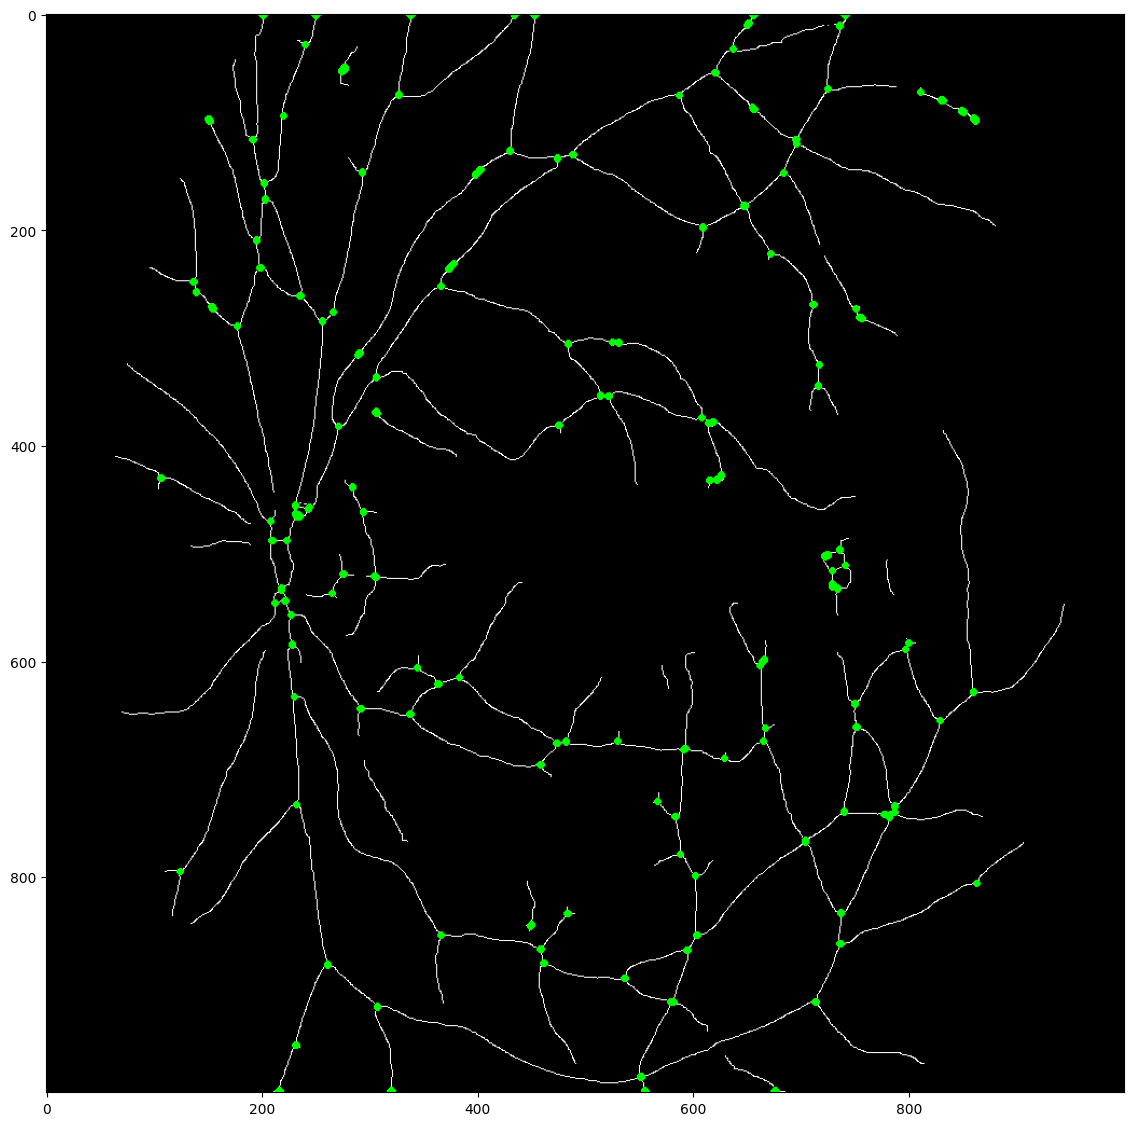

In [94]:
im, cl, d, complex, contours = seg(img)

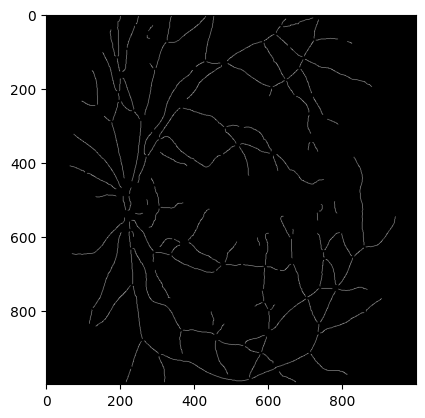

In [95]:
plt.imshow(cl, cmap='gray') 

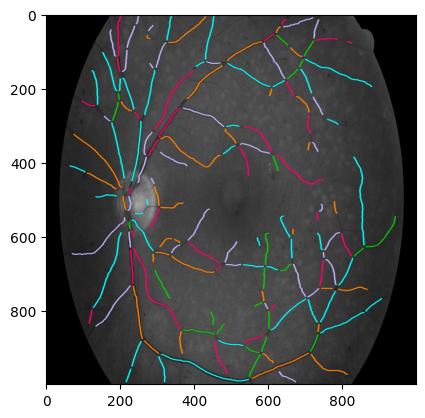

In [96]:
plt.imshow(im, cmap='gray') 

In [97]:
# Find perpendicular direction
def perpendicluar(x, y, vx, vy, d):
    '''
    find two points (C and D) that lie on a line perpendicular to another line 
    (defined by the vector [vx, vy]) and are at a distance d (max extimated diameter) from a given point (x, y)

    Args:
    (x, y): The coordinates of the point from which you want to draw the perpendicular line.
    (vx, vy): The components of a vector that defines the direction of the original line (6 pixels window)
    d: : Maximum diameter

    Returns:
    (Cx,Cy,Dx,Dy): coordinates of two points: (Cx, Cy) and (Dx, Dy) that lie on a line that is perpendicular to the original line
    '''
    # Normalize the vector, so its length is 1
    mag = math.sqrt(vx * vx + vy * vy) # magnitude (length) of the vector 
    if (vy != 0):
        vx = vx / mag
        vy = vy / mag
        temp = vx
        vx = -1 * vy
        vy = temp
        Cx = (x + vx * d)
        Cy = (y + vy * d)
        Dx = (x - vx * d)
        Dy = (y - vy * d)
    else: 
    # If vy is zero (original vector is horizontal), it simply sets the perpendicular direction to be vertical.
        Cx = (x)
        Cy = (y + d)
        Dx = (x)
        Dy = (y - d)

    return (Cx,Cy,Dx,Dy)


# Bilinear interpolation to find values at non-integral positions
def interpolate(img, x, y):
    '''
    performs bilinear interpolation on an image
    to estimate the pixel value at a non-integral (floating-point) coordinate

    Args:
    img: image Green Channel
    (x, y): Floating-point coordinates at which you want to interpolate the pixel value

    Returns:
    val: the interpolated pixel value at the floating-point coordinates (x, y)
    '''
    y1 = int(y)
    y2 = int(y)+1
    x1 = int(x)
    x2 = int(x)+1
    if(x==x1 and y==y1):
        return np.array([img[x1, y1]])[0]

    if(x==x1 and y!=y1):
        val = ((y2-y)/(y2-y1))*(img[x1, y1])+((y-y1)/(y2-y1))*(img[x1, y2])
        return np.array([val])[0]

    if(x!=x1 and y==y1):
        val = ((x2-x)/(x2-x1))*(img[x1, y1])+((x-x1)/(x2-x1))*(img[x2, y1])
        return np.array([val])[0]

    if(x!=x1 and y!=y1):
        val = (np.matmul(np.matmul(np.array([x2-x, x-x1]),np.array([[img[x1,y1], img[x1, y2]],[img[x2,y1], img[x2,y2]]])), np.array([[y2-y],[y-y1]])))/((x2-x1)*(y2-y1))
        return val[0]
        

# K-Means clustering of the points along a normal
def cluster(Z):
    '''
    performs K-means clustering on a set of points to form 3 clusters

    Args:
    Z: One-dimensional array of points

    Returns:
    res2: The array of points where each original point is replaced by the center of its cluster.
    l: The array of labels indicating to which cluster each point belongs.
    '''
    z = Z.reshape((-1,1))
    z = np.float32(Z)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1.0)
    K = 3
    ret,label,center=cv2.kmeans(z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((Z.shape))
    l = np.array(label.flatten()).reshape(Z.shape)
    return res2, l

# Selecting the lowest intensity cluster
def dia_color_min(l):
    '''
    select the cluster with the lowest intensity from a set of clusters, where each cluster is represented by an intensity value

    Args:
    l: A one-dimensional array representing cluster labels or intensities for each point.

    Returns:
    temp: A binary mask where the pixels belonging to the cluster with the lowest intensity are marked with 255, and all other pixels are 0
    '''
    l = l.reshape(-1, 1)
    #temp = np.ones(l.shape)*255
    temp = np.zeros(l.shape)
    val = np.min(l)
    temp_r = l.copy()
    for i in range(l.shape[0]):
        if(temp_r[i, 0] == val):
            temp_r[i, 0] = 255
    _, temp = cv2.threshold(l, val, 255, cv2.THRESH_BINARY_INV) 
    return temp

In [98]:
len(contours)

164

In [99]:
vassel1 = contours[0]

In [100]:
parts = np.array_split(vassel1, 3, axis=0)

In [101]:
parts[1]

array([[[659, 985]],

       [[660, 986]],

       [[661, 986]],

       [[662, 987]],

       [[663, 987]],

       [[664, 987]],

       [[665, 988]],

       [[666, 989]],

       [[667, 989]],

       [[668, 989]],

       [[669, 990]],

       [[670, 990]],

       [[671, 991]],

       [[671, 992]],

       [[672, 992]],

       [[673, 993]],

       [[674, 994]],

       [[674, 993]],

       [[673, 992]],

       [[672, 992]],

       [[671, 991]],

       [[670, 990]],

       [[669, 990]],

       [[668, 989]],

       [[667, 989]],

       [[666, 988]],

       [[665, 988]],

       [[664, 987]],

       [[663, 987]],

       [[662, 987]],

       [[661, 986]],

       [[660, 985]],

       [[659, 985]],

       [[658, 985]]], dtype=int32)

In [102]:
len(parts[1])

34

In [103]:
point = parts[1]
dl = d

In [104]:
points = point.reshape(-1, 2)

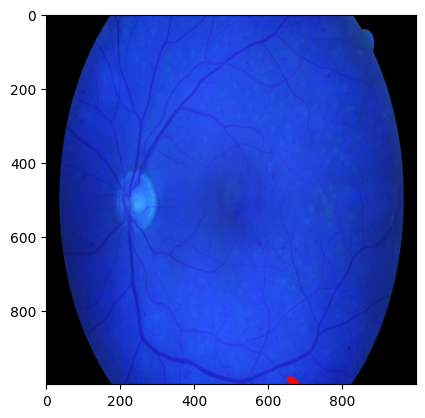

In [105]:
# Extract x and y coordinates
x_coords = points[:, 0]
y_coords = points[:, 1]
#img = cv2.resize(img, (1000, 1000))
plt.imshow(img, cmap='gray')  # Use an appropriate colormap
plt.scatter(x_coords, y_coords, color='red', s=10)  # Adjust the size as needed
# Show the plot
plt.show()

In [110]:
g = img[:,:,1]

In [111]:
'''
for j in range(3, point.shape[0] - 3, 1):
    print(j)
    print(point[j+ 3][0][0], point[j- 3][0][0])
    vx = point[j+ 3][0][0] - point[j- 3][0][0]
    print(point[j+ 3][0][1], point[j- 3][0][1])
    vy = point[j+ 3][0][1] - point[j- 3][0][1]
    print(vx, vy)
'''

'\nfor j in range(3, point.shape[0] - 3, 1):\n    print(j)\n    print(point[j+ 3][0][0], point[j- 3][0][0])\n    vx = point[j+ 3][0][0] - point[j- 3][0][0]\n    print(point[j+ 3][0][1], point[j- 3][0][1])\n    vy = point[j+ 3][0][1] - point[j- 3][0][1]\n    print(vx, vy)\n'

In [112]:
# Finding normal points for each centreline point and stroing their coordinates and values
tempo = g.copy()
nrp = []
nrv = []
for j in range(3, point.shape[0] - 3, 1):
    
    vx = point[j+ 3][0][0] - point[j- 3][0][0]
    vy = point[j+ 3][0][1] - point[j- 3][0][1]
    #print(vx, vy)
    
    (Cx, Cy, Dx, Dy) = perpendicluar(point[j][0][0], point[j][0][1], vx,
                                     vy, int(dl)) #disctance to be 40
    #print((Cx, Cy, Dx, Dy))
   
    cv2.line(tempo, (int(Cx), int(Cy)), (int(Dx), int(Dy)), 255, thickness=1)
    D = int(2*dl) #dyatance is 40
    #print(D)
    
    normal_points = []
    values = []
    normal_points.append((Dy, Dx))
    values.append(interpolate(g, Dy, Dx))
    #print(values)
    
    for i in range(1, D): #from 1 to D-1 for D-1 points at distance of 1 pixe
            part = ((((D-i)*Dy+i*Cy))/D, (((D-i)*Dx+i*Cx))/D)
            normal_points.append(part)
            values.append(interpolate(g, (((D-i)*Dy+i*Cy))/D, (((D-i)*Dx+i*Cx))/D ))
    normal_points.append((Cy, Cx))
    values.append(interpolate(g, Cy, Cx))
    nrp.append(np.array(normal_points))
    nrv.append(np.array(values))
nrp = np.array(nrp)
nrv = np.array(nrv)

In [113]:
X = np.arange(0, nrv.shape[1]).reshape(1, -1)
Y = np.arange(0, nrv.shape[0]).reshape(-1, 1)
Z = nrv

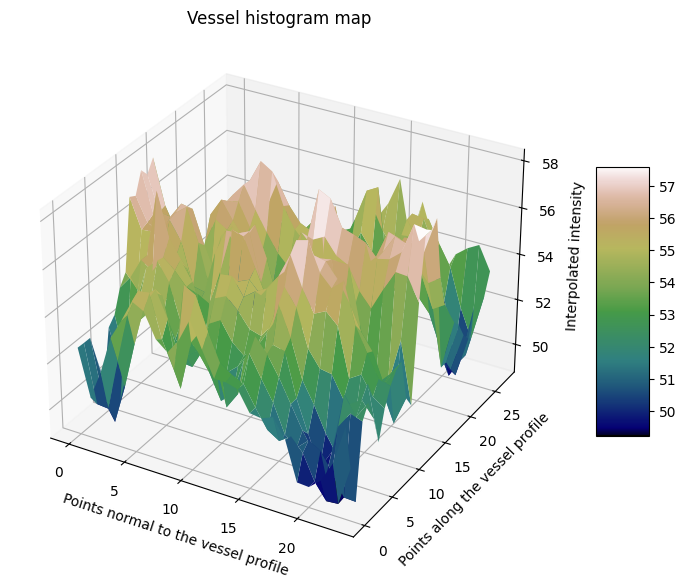

In [114]:
fig = plt.figure(figsize=(12,7))
ax1 = fig.add_subplot(111, projection='3d')


mycmap = plt.get_cmap('gist_earth')
ax1.set_title('Vessel histogram map')
ax1.set_xlabel('Points normal to the vessel profile')
ax1.set_ylabel('Points along the vessel profile')
ax1.set_zlabel('Interpolated intensity')
surf1 = ax1.plot_surface(X, Y, Z, cmap=mycmap)
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)

plt.show()

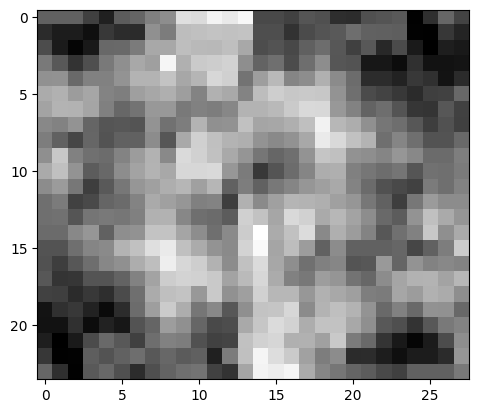

In [115]:
plt.imshow(Z.T, cmap='gray')

In [116]:
# Clustering points along each normal
L = np.zeros(Z.shape)
Zc = np.zeros(Z.shape)
for i in range(Z.shape[0]):
    Zc[i, :], L[i,:] = cluster(Z[i,:])

im_dia = np.ones(Z.shape)

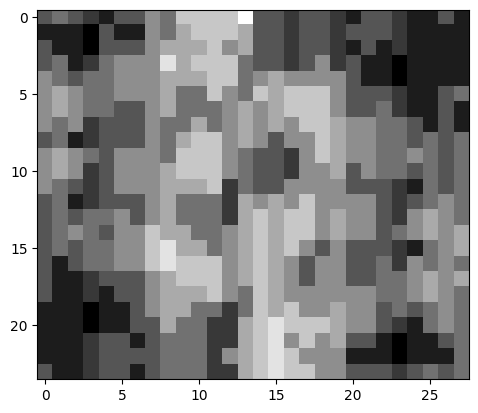

In [117]:
plt.imshow(Zc.T, cmap='gray')

In [118]:
# CLR correction i.e, joining broken lines along every normal
for i in range(L.shape[0]):
    pred = dia_color_min(Zc[i])  
    kernel = np.ones((5, 1), np.uint8)
    # Morphological Operations
    d_dia = cv2.dilate(pred, kernel) # causes bright regions (where pixels are 255) in the mask to expand, effectively joining nearby bright regions.
    e_dia = cv2.erode(d_dia, kernel) # shrinks the bright regions but retains the connections made during dilation
    im_dia[i] = e_dia.reshape(-1)

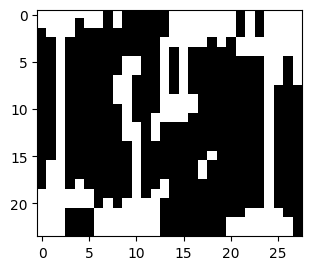

In [119]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 1)
plt.imshow(im_dia.T, cmap='gray')

In [120]:
# joining broken lines along the centreline
kernel = np.ones((5, 1), np.uint8)
im_d_dia = cv2.dilate(im_dia, kernel)
im_e_dia = cv2.erode(im_d_dia, kernel) 

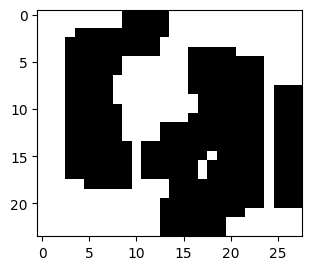

In [121]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 2)
plt.imshow(im_e_dia.T, cmap='gray')

In [122]:
# using symmetry to remove unwanted false positives
im_e_dia_rev = im_e_dia.copy()
for i in range(im_e_dia.T.shape[0]):
    im_e_dia_rev.T[i] = im_e_dia.T[im_dia.T.shape[0]-1-i]
    
pred_dia_cl = cv2.bitwise_and(im_e_dia, im_e_dia_rev, mask=None)

In [123]:
# Finally smoothing the profile edges by joining pixels which are horizontally at a distance less than 20px
kernel = np.ones((20, 1), np.uint8)
pred_d_dia = cv2.dilate(pred_dia_cl, kernel)
pred_e_dia = cv2.erode(pred_d_dia, kernel) 

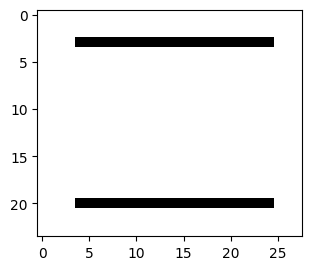

In [124]:
plt.figure(figsize=(10, 10))
plt.subplot(3, 1, 3)
plt.imshow(pred_e_dia.T, cmap='gray')

In [125]:
#Storing the diameters
diameters = []

for i in range(im_e_dia.shape[0]):
    dia = np.sum(1*(pred_e_dia[i]!=0))
    diameters.append(dia)
    


diameters = np.array(diameters).reshape(len(diameters), 1)
print('Average diameter length:', np.mean(diameters))
print('Median diameter length:', np.median(diameters))
print('Standard deviation:', np.std(diameters)/len(diameters))

Average diameter length: 22.5
Median diameter length: 22.0
Standard deviation: 0.030929478706587094


In [34]:
'''
# Drawing rough diameters on the image 
final_ann = img.copy()

for j in range(3, point.shape[0] - 3, 1):
    vx = point[j+ 3][0][0] - point[j- 3][0][0]
    vy = point[j+ 3][0][1] - point[j- 3][0][1]
    (Cx, Cy, Dx, Dy) = perpendicluar(point[j][0][0], point[j][0][1], vx,
                                     vy, diameters[i]//2) #disctance to be 40
    cv2.line(final_ann, (int(Cx), int(Cy)), (int(Dx), int(Dy)), (0, 0, 0), thickness=1)
'''

/var/folders/9w/6tn98ftd2vncy9w7tdh_vgq80000gq/T/ipykernel_28032/3850990714.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cv2.line(final_ann, (int(Cx), int(Cy)), (int(Dx), int(Dy)), (0, 0, 0), thickness=1)


In [ ]:
'''
cv2.namedWindow('image', cv2.WINDOW_NORMAL)
cv2.resizeWindow('image', (int(final_ann.shape[1]/2), int(final_ann.shape[0]/2)))
cv2.moveWindow('image', 40,30)  # Move it to (40,30)
cv2.imshow('image', final_ann)
cv2.waitKey()
cv2.destroyAllWindows()
'''

## From library

Maximum diameter: 16.684356689453125 at the point: (604, 386)
Select the vessel and press Q after selection.


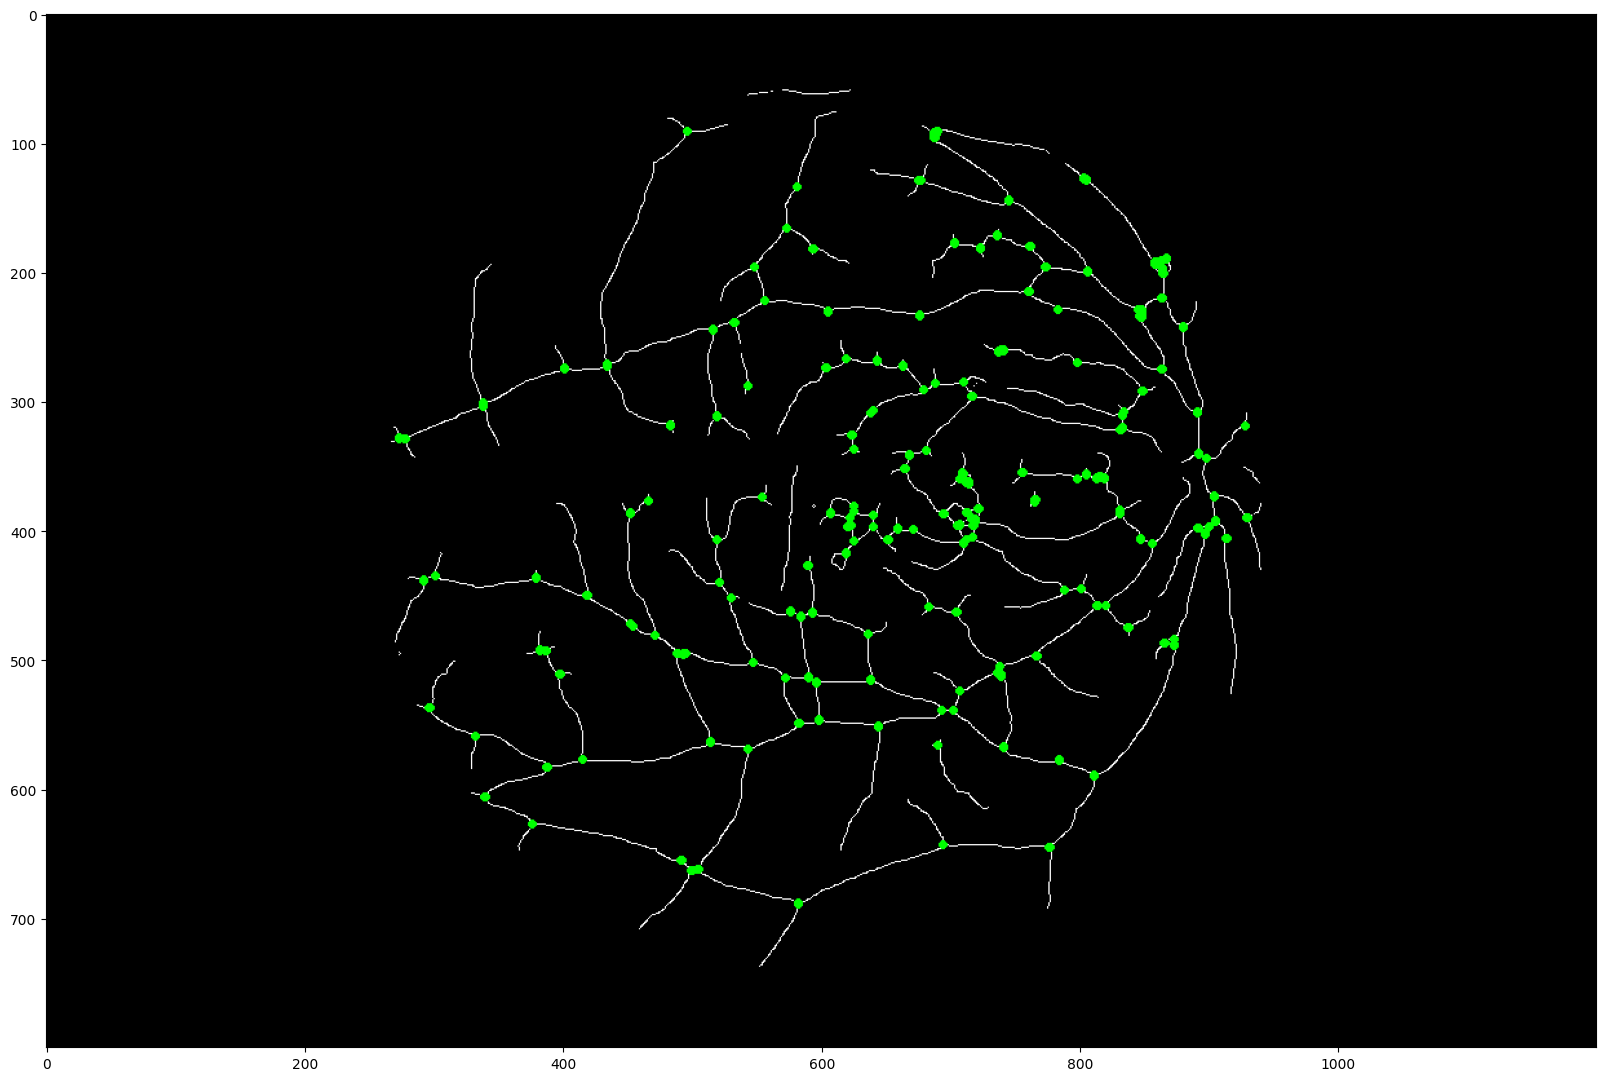

In [17]:
im, cl, d = segment.seg(img)

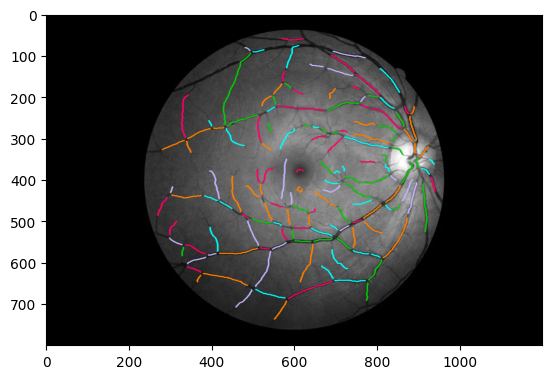

In [18]:
plt.imshow(im)

In [6]:
diameter_calc.diameter(img)

Maximum diameter: 20.504364013671875 at the point: (732, 348)
Select the vessel and press Q after selection.


error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'pointPolygonTest'
> Overload resolution failed:
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type
>  - Can't parse 'pt'. Sequence item with index 0 has a wrong type


In how many parts you want to divide the selected vessel (Please enter an integer <=5):   2


Select the required part and press Q.


TypeError: object of type 'NoneType' has no len()